In [116]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from keras.applications.vgg16 import VGG16
from keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

from sklearn.decomposition import PCA

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import read_filenames, prepare_datasets
from processing import find_bounding_boxes, extract_and_resize, process_image, load_image
from data_generator import ImageDataGenerator

In [105]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'
#path = '/Users/julia/Desktop/semestr-4/ml/projekty/projekt-2/galaxies_data/images_gz2/images'

galaxies = read_filenames(path)

In [3]:
galaxies_train, galaxies_val, galaxies_test = prepare_datasets(galaxies, 100000)

In [4]:
print(f'Size of train sample: {len(galaxies_train)}')
print(f'Size of validation sample: {len(galaxies_val)}')
print(f'Size of test sample: {len(galaxies_test)}')

Size of train sample: 64000
Size of validation sample: 16000
Size of test sample: 20000


## Extracting galaxy from an image

We will use the fact that galaxy of our interest is in the center of the image and using bounding boxes we will find appropriate square to crop the image.

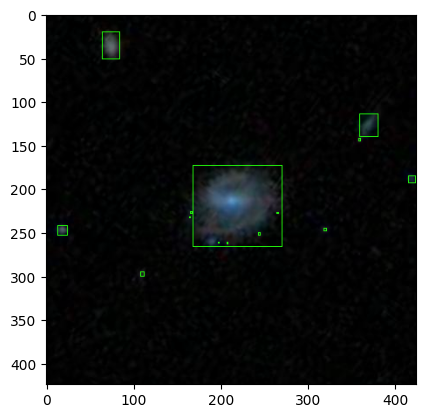

In [5]:
image = load_image(galaxies_train[3721])

image_bb = find_bounding_boxes(image, 30)
plt.imshow(image_bb)
plt.show()

Out of all of found bounding boxes we choose the one that is both close to the center and not relatively small in size. Implementation can be found in src/processing.py file, extract_and_resize function. Below we show results of such an operation.

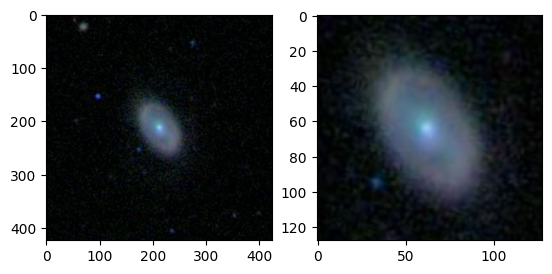

In [15]:
image = load_image(galaxies_train[random.randint(0, len(galaxies_train) - 1)])
plt.subplot(1, 2, 1)
plt.imshow(image)

image_cropped = extract_and_resize(image, 20)
plt.subplot(1, 2, 2)
plt.imshow(image_cropped)
plt.show()

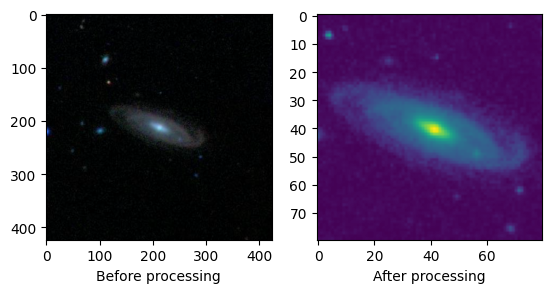

In [36]:
random_galaxy = galaxies_train[random.randint(0, len(galaxies_train) - 1)]

image = cv.imread(random_galaxy)
plt.subplot(1, 2, 1)
plt.xlabel('Before processing')
plt.imshow(image)

processed_image = process_image(random_galaxy, 20, (80, 80))
plt.subplot(1, 2, 2)
plt.xlabel('After processing')
plt.imshow(processed_image)
plt.show()

## Autoencoder for image denoising

Training will be performed in batches in order to reduce RAM usage. ImageDataGenerator is a class that yields batches of images for training a model. Class implementation can be found in src/data_generator.py

In [37]:
batch_size = 32
img_size = 80

train_gen = ImageDataGenerator(galaxies_train, batch_size, img_size)
val_gen = ImageDataGenerator(galaxies_val, batch_size, img_size)

In [47]:
encoder = Sequential([
    Flatten(input_shape=[80, 80]),
    Dense(1000, activation="relu"),
    Dense(800, activation="relu"),
    Dense(600, activation="relu"),
    Dense(400, activation="relu"),
    Dense(200, activation="relu"),
    Dense(100, activation="relu"),
    Dense(50, activation="relu")
])

# Define the decoder
decoder = Sequential([
    Dense(100, input_shape=[50], activation="relu"),
    Dense(200, activation="relu"),
    Dense(400, activation="relu"),
    Dense(600, activation="relu"),
    Dense(800, activation="relu"),
    Dense(1000, activation="relu"),
    Dense(80*80, activation="sigmoid"),
    Reshape([80, 80])
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [49]:
for epoch in range(10):
    print(f"Epoch {epoch + 1}/{10}")

    autoencoder.fit(
        train_gen,
        epochs=1,
        validation_data=val_gen,
    )

    train_gen.on_epoch_end()
    val_gen.on_epoch_end()

    print()

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 174s 87ms/step - loss: 0.2840 - val_loss: 0.2823

Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 90ms/step - loss: 0.2830 - val_loss: 0.2818

Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 480s 240ms/step - loss: 0.2827 - val_loss: 0.2818

Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 218s 109ms/step - loss: 0.2822 - val_loss: 0.2813

Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 92ms/step - loss: 0.2818 - val_loss: 0.2808

Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 186s 93ms/step - loss: 0.2813 - val_loss: 0.2807

Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 93ms/step - loss: 0.2806 - val_loss: 0.2807

Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 95ms/step - loss: 0.2812 - val_loss: 0.2804

Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 206s 103ms/step - loss: 0.2811 - val_loss: 0.2804

Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 95ms/step - loss: 0.2811 - val_loss: 0.2805



In [52]:
processed_images_val = []

for galaxy in galaxies_val[:100]:
    image = process_image(galaxy, 30, target_size=(80, 80))
    processed_images_val.append(image)

X_val = np.array(processed_images_val)

In [141]:
predicitions = autoencoder.predict(X_val[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


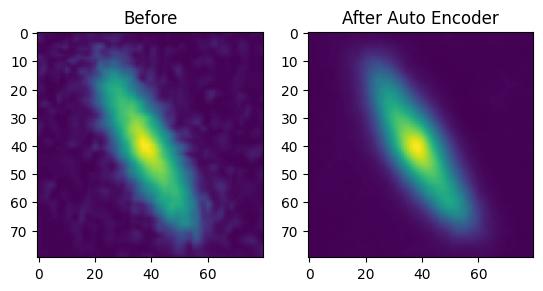

In [128]:
index = random.randint(0, len(predicitions) - 1)

plt.subplot(1, 2, 1)
plt.title("Before")
plt.imshow(X_val[index])

plt.subplot(1, 2, 2)
plt.title("After Auto Encoder")
plt.imshow(predicitions[index])
plt.show()

## Converting to feature vectors

We will use pretrained CNN and remove top classification layers and extract features from the intermediate layers. These features can then be used to represent each image, and clustering algorithms such as K-means can be applied to cluster them.

In [130]:
model = VGG16(include_top=False, input_shape=(80, 80, 3)) # VGG16 accepts only 3 inputs channels
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 68s 1us/step


In [166]:
def extract_features(image, model):
    img = np.array(image)
    img = np.stack((img,) * 3, axis=-1)
    reshaped_img = img.reshape(1, 80, 80, 3)
    features = model.predict(reshaped_img)
    return features

In [173]:
data = {}

for galaxy in galaxies_train[:1000]:
    image = process_image(galaxy, 20, (80, 80))
    image = autoencoder.predict(np.array([image]))[0]
    feat = extract_features(image, model)
    data[galaxy] = feat
          
filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))
feat = feat.reshape(feat.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [175]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [176]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 12800
Components after PCA: 100
